In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import os, sys

import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import yaml
import scipy
import numpy as np
import pandas as pd

proj_root = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.append(proj_root)

from minatar import Environment

from minatar_dqn.my_dqn import Conv_QNET
from minatar_dqn.redo import apply_redo_parametrization

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

from experiments.experiment_utils import (
    seed_everything,
    search_files_containing_string,
    split_path_at_substring,
    collect_training_output_files,
)

For each checkpoint of an experiment we want to prune with different pruning factors and compare against different thresholds + redo scores

In [73]:
# Collect all paths to models in a specified folder
file_dir = os.path.dirname(os.path.abspath("."))
training_outputs_folder_path = os.path.join(proj_root, "experiments", "training", "outputs")
pruning_outputs_folder_path = os.path.join(file_dir, "outputs")
training_timestamp_folder = "2023_05_15-18_23_40"

experiments_folder = os.path.join(training_outputs_folder_path, training_timestamp_folder)

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

for exp in experiment_paths:
    exp["models_folder_path"] = os.path.dirname(exp["model_path"])

def compare_redo_pruning(exp_paths):

    training_stats_data = torch.load(exp_paths["stats_path"])
    redo_scores = training_stats_data["redo_scores"]["policy"]

    checkpoints_paths = search_files_containing_string(
        exp_paths["models_folder_path"], "mck", substring_location="containing"
    )

    # read the config so that the model architecture can be loaded
    with open(exp_paths["config_path"], "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)

    results = []
    for check_index, checkpoint_path in enumerate(checkpoints_paths):
        # Get the state of the model
        checkpoint_models_state = torch.load(checkpoint_path)
        checkpoint_model = Conv_QNET(in_features = (4, 10, 10), 
                                    in_channels = 4, 
                                    num_actions = 6, 
                                    **cfg["estimator"]["args_"])
        checkpoint_model = apply_redo_parametrization(checkpoint_model, tau=0.1)
        checkpoint_model.load_state_dict(checkpoint_models_state["policy_model_state_dict"])
        model_state = checkpoint_model.state_dict()

        # Compute kendall rank correlation coefficient for each layer
        layer_weight_keys = ["features.0.weight", "features.2.weight", "fc.0.weight"]
        for i, layer_key in enumerate(layer_weight_keys):
            weights = model_state[layer_key]

            # compute the weight of the neurons in this layer
            if weights.dim() > 2:
                l1_norms = torch.sum(torch.abs(weights), dim=(1, 2, 3))
            else:
                l1_norms = torch.sum(torch.abs(weights), dim=(1))

            neuron_rankings = torch.argsort(l1_norms)

            redo_score = redo_scores[check_index][i]
            redo_rankings = torch.argsort(redo_score)

            # Calculate the Kendall rank correlation coefficient
            # k_corr, k_pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)
            k_corr, k_pval = scipy.stats.kendalltau(l1_norms, redo_score)


            # Calculate the Spearman rank correlation coefficient
            # s_corr, s_pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)
            s_corr, s_pval = scipy.stats.spearmanr(l1_norms, redo_score)


            new_row = {"checkpoint": os.path.basename(checkpoint_path),
                        "epoch": check_index, 
                        "layer": layer_key,
                        "kendall_corr": k_corr, 
                        "kendall_pval": k_pval,
                        "spearman_corr": s_corr, 
                        "spearman_pval": s_pval
                        }
            results.append(new_row)

    return pd.DataFrame(results)
    

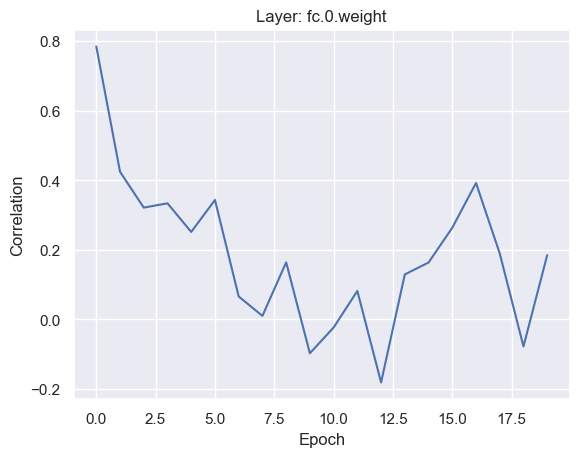

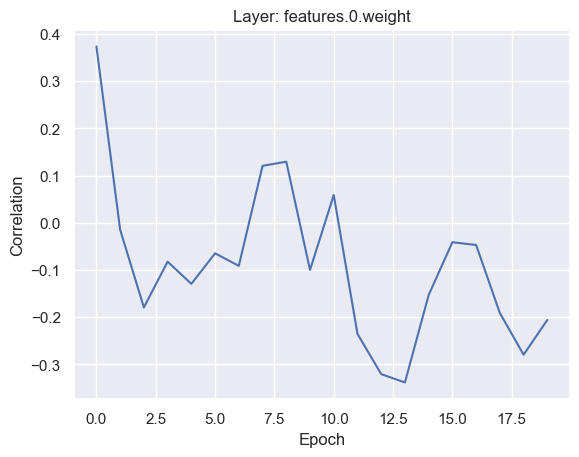

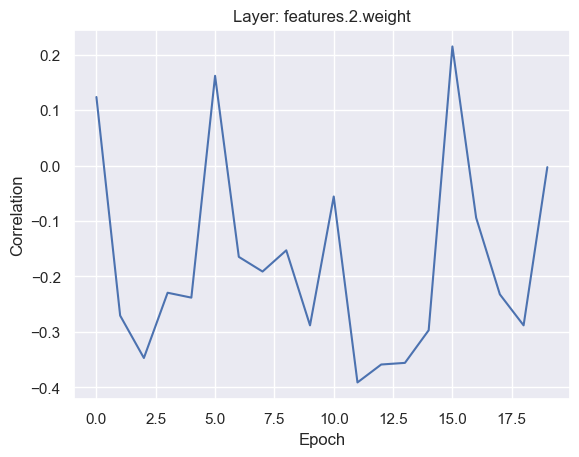

In [74]:
results_df = compare_redo_pruning(experiment_paths[0])

# Group the DataFrame by layer
grouped_df = results_df.groupby('layer')

corr_col = 'spearman_corr'

# Iterate over each layer and create scatter plots
for layer, data in grouped_df:
    plt.figure()
    plt.plot(data['epoch'], data[corr_col])  
    plt.title(f'Layer: {layer}')
    plt.xlabel('Epoch')
    plt.ylabel(corr_col)
    plt.show()

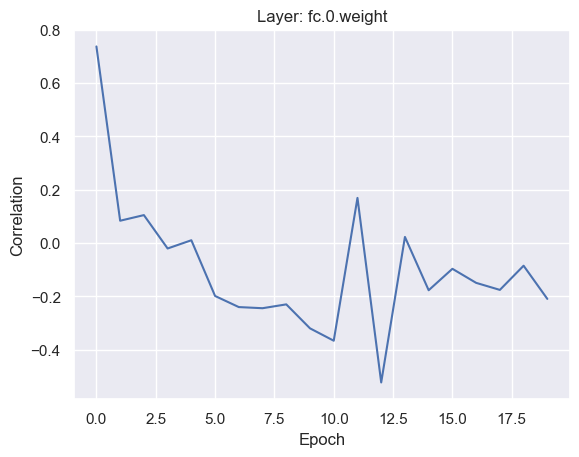

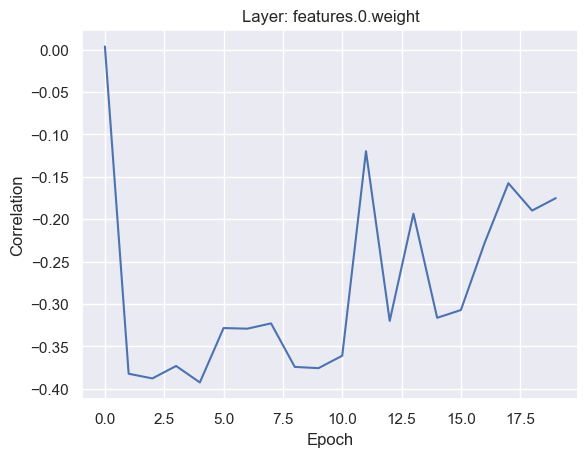

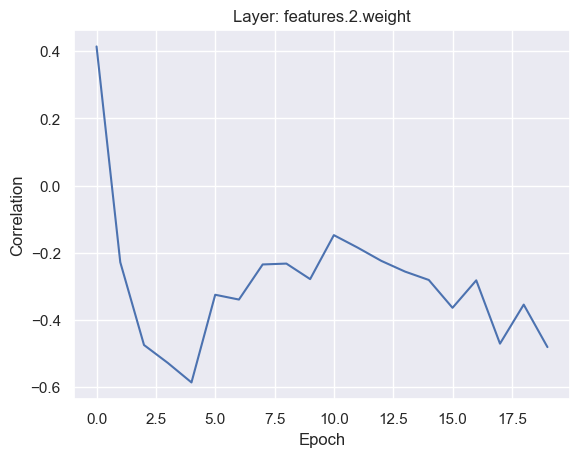

In [75]:
results_df = compare_redo_pruning(experiment_paths[1])

# Group the DataFrame by layer
grouped_df = results_df.groupby('layer')

corr_col = 'spearman_corr'

# Iterate over each layer and create scatter plots
for layer, data in grouped_df:
    plt.figure()
    plt.plot(data['epoch'], data[corr_col])  
    plt.title(f'Layer: {layer}')
    plt.xlabel('Epoch')
    plt.ylabel(corr_col)
    plt.show()

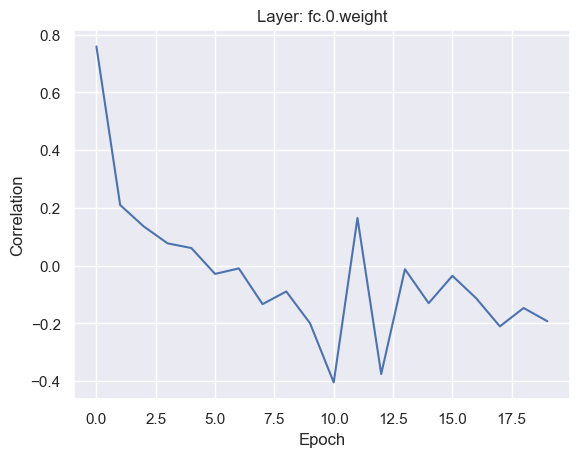

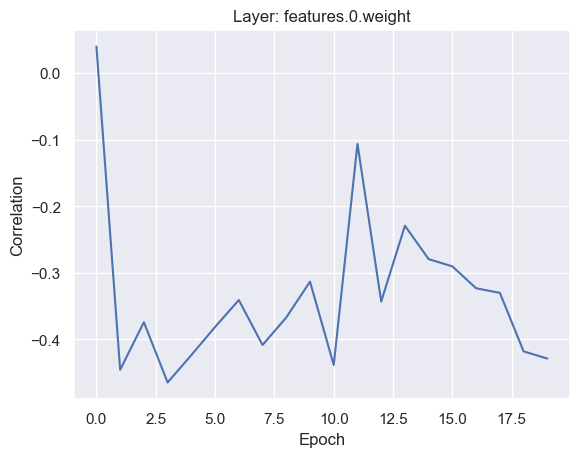

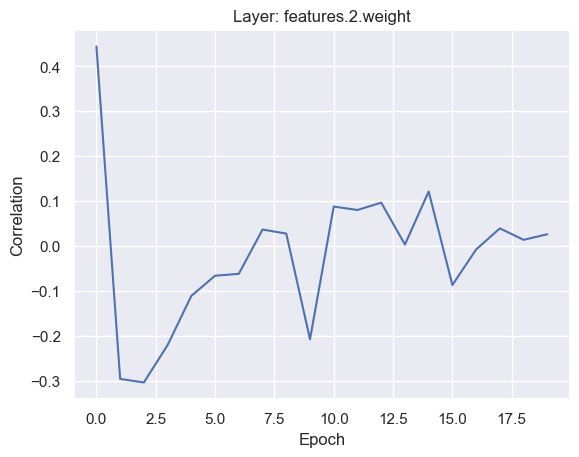

In [76]:
results_df = compare_redo_pruning(experiment_paths[2])

# Group the DataFrame by layer
grouped_df = results_df.groupby('layer')

corr_col = 'spearman_corr'

# Iterate over each layer and create scatter plots
for layer, data in grouped_df:
    plt.figure()
    plt.plot(data['epoch'], data[corr_col])  
    plt.title(f'Layer: {layer}')
    plt.xlabel('Epoch')
    plt.ylabel(corr_col)
    plt.show()

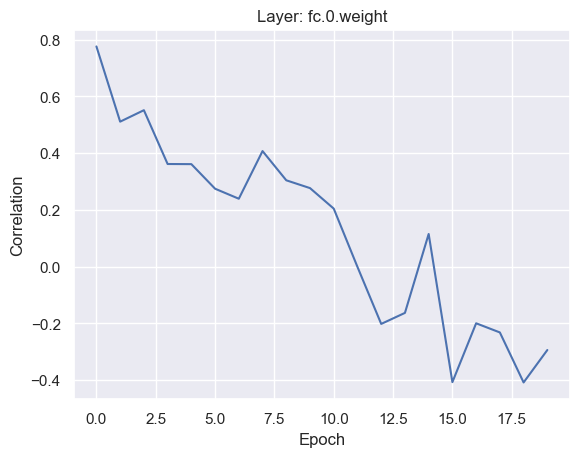

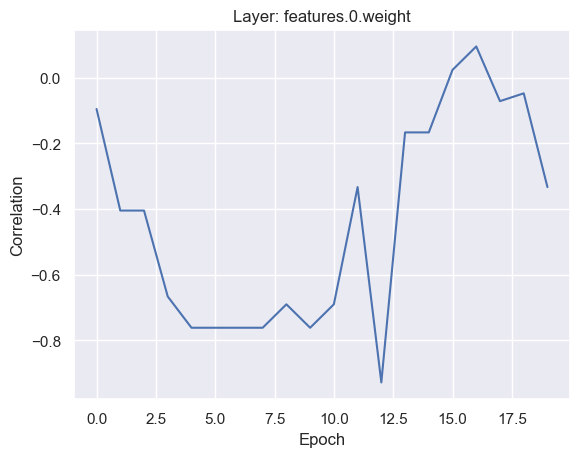

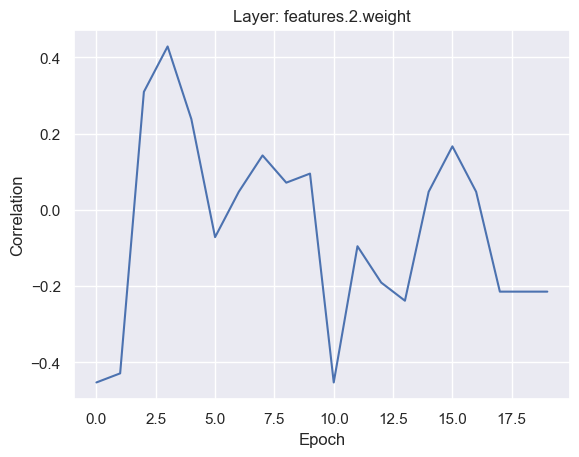

In [77]:
results_df = compare_redo_pruning(experiment_paths[3])

# Group the DataFrame by layer
grouped_df = results_df.groupby('layer')

corr_col = 'spearman_corr'

# Iterate over each layer and create scatter plots
for layer, data in grouped_df:
    plt.figure()
    plt.plot(data['epoch'], data[corr_col])  
    plt.title(f'Layer: {layer}')
    plt.xlabel('Epoch')
    plt.ylabel(corr_col)
    plt.show()

In [31]:
t = torch.tensor([[0, 1, 3], [-1, 1, 0]])
torch.sum(torch.abs(t), dim=(1))

tensor([4, 2])

In [49]:
rank1 = torch.tensor([1, 2, 3, 4, 5])
rank2 = torch.tensor([1, 2, 3, 4, 5])

corr, pvalue = scipy.stats.kendalltau(rank1, rank2)
print("Kendall's rank correlation coefficient: ", corr)

correlation, p_value = scipy.stats.spearmanr(rank1, rank2)
print("Spearman's rank correlation coefficient:", correlation)

Kendall's rank correlation coefficient:  0.9999999999999999
Spearman's rank correlation coefficient: 0.9999999999999999


In [51]:
rank1 = torch.tensor([1, 2, 3, 4, 5])
rank2 = torch.tensor([2, 3, 1, 4, 5])

corr, pvalue = scipy.stats.kendalltau(rank1, rank2)
print("Kendall's rank correlation coefficient: ", corr)

correlation, p_value = scipy.stats.spearmanr(rank1, rank2)
print("Spearman's rank correlation coefficient:", correlation)

Kendall's rank correlation coefficient:  0.6
Spearman's rank correlation coefficient: 0.7


In [39]:
rank1 = [1, 2, 3, 4, 5]
rank2 = [2, 1, 3, 5, 4] 

corr, pvalue = scipy.stats.kendalltau(rank1, rank2)
print("Kendall's rank correlation coefficient: ", corr)

correlation, p_value = scipy.stats.spearmanr(rank1, rank2)
print("Spearman's rank correlation coefficient:", correlation)

Kendall's rank correlation coefficient:  0.6
Spearman's rank correlation coefficient: 0.7999999999999999


In [36]:
rank1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rank2 = [1, 2, 3, 4, 5, 10, 9, 8, 7, 6] 

corr, pvalue = scipy.stats.kendalltau(rank1, rank2)
print("Kendall's rank correlation coefficient: ", corr)

correlation, p_value = scipy.stats.spearmanr(rank1, rank2)
print("Spearman's rank correlation coefficient:", correlation)

Kendall's rank correlation coefficient:  0.5555555555555555
Spearman's rank correlation coefficient: 0.7575757575757575


In [20]:
neuron_rankings

tensor([ 5, 40, 23, 58, 20, 51, 26, 57, 52, 41, 37, 54,  7, 42, 13, 53,  4, 14,
        15, 62, 18, 25, 30,  2, 34, 56, 43, 59, 35,  9,  1, 32, 28, 12, 38, 36,
        48,  0,  8, 21, 60, 17, 22, 24, 55, 29, 50,  3, 49,  6, 33, 45, 44, 16,
        27, 11, 39, 63, 10, 19, 61, 47, 46, 31])

In [68]:
redo_rankings

tensor([ 0, 48,  2, 54,  4,  5, 51,  7, 52, 53, 10, 42, 41, 13, 14, 15, 38, 37,
        57, 58, 20, 60, 62, 23, 40, 25, 26, 29, 30, 44, 16, 36, 61,  3, 50, 34,
        33, 21, 27, 31, 63, 28, 46, 49, 47, 39, 22, 17, 43,  6, 45, 19, 11, 18,
        56, 59, 35,  1, 24,  8,  9, 55, 32, 12])

In [51]:
pvalue

0.8943512599699821

In [ ]:
import pandas as pd

# Create an empty DataFrame with the desired column names
results_df = pd.DataFrame(columns=['experiment', 'accuracy'])

# Run experiments and append results to the DataFrame
for i in range(10):
    # Run experiment and get accuracy
    accuracy = run_experiment(i)

    # Append results to the DataFrame
    new_row = {'experiment': i, 'accuracy': accuracy}
    results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])])

# Print the final results DataFrame
print(results_df)
